# Rigorozní odhady prvního vlastního čísla p-laplaciánu 

## varianta $u$

Řešíme úlohu 
\begin{equation}
-\Delta_p u =\lambda |u|^{p-2}u, \; t \in (0,1)\\
u(0)=u(1)=0
\end{equation}
kde $\Delta_p u := \left(|u'|^{p-2}u' \right)'$.

Přesná hodnota prvního vlastního čísla je:

$$\lambda_1 = (p-1)\left( \frac{2\frac{\pi/p}{\sin{\pi/p}}}{b-a} \right)^p,$$

přesná hodnota první vlastní funkce:

$$e_p =(p-1)^{-\frac{1}{p}} \sin_p{\left( \pi_p\frac{x-a}{b-a} \right)}$$


![vl-cislo-fce](vl-cislo-fce.png)

### Algoritmus:
1. úlohu vyřešit numericky metodou střelby
2. získané řešení $u$ proložit **ne-intervalově** křivkou (kubický spline?)
3. $u$ zderivovat - půjde snadno, je to polynom
4. vyjádřit $\Delta_p u = \left(|u'|^{p-2}u'\right)'$ nejde jako polynom, proto použít AutoDiff. Ten ale neumí pracovat s koeficientama jako intervaly
4. dosadit do vztahu pro horní/dolní odhad a intervalově vypočítat

#### Postup pro řešení pomocí shooting method:
- převedu na soustavu:
\begin{equation}
u_1' = |u_2|^{\frac{p}{p-1}-2} u_2\\
u_2' = -\lambda |u_1|^{p-2}u_1
\end{equation}
- tu řeším jako IVP s levou okrajovou podmínkou a nějakým pevným $\lambda$
- bisekcí měním $\lambda$ až se napravo dostanu kam potřebuju ($u=0$)


#### Problémy:
- až do konečného vyjádření dolního odhadu nepočítám s intervaly
- AutoDiff neumí pracovat s funkcí, která obsahuje intervaly. Do vypočtené derivace ale dosadit interval jde


In [3]:
using DifferentialEquations
using Plots; gr()
using IntervalArithmetic
#using DataInterpolations
using LinearAlgebra
using ForwardDiff

Numerické řešení přes střelbu. 

Počáteční podmínka nastavena na $\boldsymbol{u}_0 = (0, 1)$, časový krok $\Delta t = 0.01$

---

Zatím to vypadá, že řešení IVP v Julii funguje jen pro P>=2 (případ P=2 nás ale vlastně nezajímá). Zjistit, proš nefunguje řešení pro 1<P<2

- důvod je v tom, že počáteční podmínka pro $u_1$ je $u_1(0)=0$ a tak v druhé rovnici hned na začátku dělím nulou. Řešením je to trochu posunout nahoru, ale to je pak řešení úplně blbě. Zkusím to ještě konfigurací řešiče
    - možná by stačilo nějak řešiči říct, ať to _neřeší_ v prvním bodě, někdo to v těch parametrech bylo

In [4]:
# nastavení p a přesná hodnota λ₁
P=3
λ1 = (P-1)*(2*(π/P)/(sin(π/P)))^P

28.28876197600255

Numericky získané první vlastní číslo λ₁: 28.28876197305467
Chyba proti přesnému řešení: 2.9478819385531096e-9


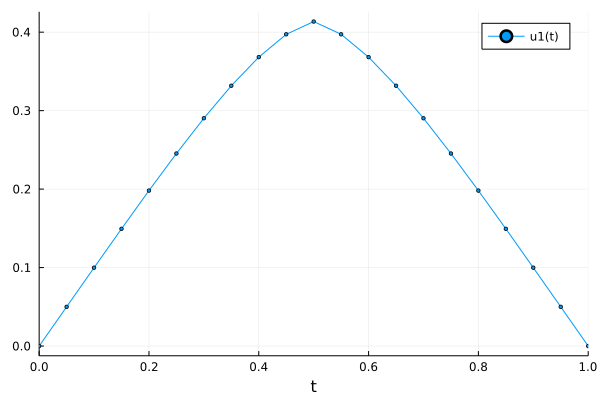

In [5]:
# řešení diferenciální soustavy metodou střelby

function sl(du,u,p,t) # parametr p je odhad na λ₁ a p z p-laplacianu
    λ, r = p
    du[1] = abs(u[2])^(r/(r-1) - 2)*u[2]
	du[2] = -λ * abs(u[1])^(r-2)*u[1]
end

u0 = [0.0; 1.0;] # počáteční podmínka
tn = 21
ts = 1.0/(tn-1) #0.05 # časový krok

e = 1e-12 # zastavovací podmínka
a,b = (3.,40.)
s = (a + b)/2

while (b-a) >= e
    prob = ODEProblem(sl, u0, (0.0, 1.0), (s, P))
    sol = solve(prob, saveat=ts, abstol=1e-8,reltol=1e-8)

    if sol(1)[1] == 0 # bere hodnotu v t=1 (pravej konec) pro první řešení soustavy u₁
        break
    else
        probA = ODEProblem(sl, u0, (0.0, 1.0), (a, P))
        solA = solve(probA, saveat=ts, abstol=1e-8,reltol=1e-8)
        
        probS = ODEProblem(sl, u0, (0.0, 1.0), (s, P))
        solS = solve(probS, saveat=ts, abstol=1e-8,reltol=1e-8)

        if solA(1)[1] * solS(1)[1] < 0
            b = s
        else
            a = s
        end
        s = (a+b)/2
    end
end
    
prob = ODEProblem(sl, u0, (0.0, 1.0), (s, P))
sol = solve(prob, saveat=ts, abstol=1e-8,reltol=1e-8)

println("Numericky získané první vlastní číslo λ₁: $s")
println("Chyba proti přesnému řešení: $(λ1-s)")
plot(sol,vars=(0,1),marker=2)

Vytáhnu řešení do proměnných t,u. K u přičtu nějakou malou hodnotu, aby bylo na 0 i intervalově.

In [6]:
to_add = 0.1

t = sol.t
u = [u[1]+to_add for u in sol.u]
u[end] = to_add;
#plot(t,u1, marker=2)
#plot!(t,u2,marker=2)



Vypočteme koeficienty (kubického) spline proloženého řešením $u$

In [7]:
# výpočet kubického splinu

# matice A
n=length(u)
dv = [4 for i in 1:n-2]
ev = [1 for i in 1:n-3]
A = Array(SymTridiagonal(dv,ev))
A_inv = inv(A) #inverze

#pravá strana
h = ts
# sestavení pravé strany
rhs = []
for i in 3:length(u)
    append!(rhs, 6/h^2 * (u[i] - 2 * u[i-1] + u[i-2]))
end

# vypočte vektor druhých derivací potřebný na výpočet koeficientů
# druhá derivace na krajích je nastavena na -1

d2v = []
append!(d2v, -1)
append!(d2v, A_inv*rhs)
append!(d2v, -1)
d2v

# výpočet koeficientů jednotlivých oblouků splinu
csc = [] #@interval zeros(4, length(solu)-1)
for i in 1:length(u)-1
    a=b=c=d=0
    a = (d2v[i+1]-d2v[i])/(6*h)
    b = d2v[i]/2 
    c = (u[i+1] - u[i])/h - h*(2*d2v[i]+d2v[i+1])/6
    d = u[i]
    append!(csc, [[a,b,c,d]])
    #csc[1, i] = a
end
csc

20-element Vector{Any}:
 [3.240559572064882, -0.5, 1.016751251358126, 0.1]
 [-0.361847358182394, -0.013916064190267616, 0.9993887814819459, 0.14999263251441441]
 [-0.5905699596943607, -0.06819316791762672, 0.9952833198765512, 0.19988205050826324]
 [-0.8644430189086113, -0.15677866187178083, 0.9840347283870808, 0.24940191233733494]
 [-1.0927344175872535, -0.28644511470807255, 0.9618735395580882, 0.29810364672464595]
 [-1.6692371726884427, -0.4503552773461606, 0.9250335199553765, 0.3453446191135818]
 [-1.353181807170695, -0.700740853249427, 0.8674787134255971, 0.39026175227139914]
 [-5.3189744266875945, -0.9037181243250313, 0.7872557645468742, 0.4317146880836591]
 [3.8755075655548463, -1.7015642883281705, 0.656991643914214, 0.4681533091968543]
 [-53.85072009163093, -1.1202381534949435, 0.5159015218230583, 0.4972334191174389]
 [53.85119773022394, -9.197846167239584, -2.694213668108514e-6, 0.5134965598134006]
 [-3.8761028519624703, -1.1201665077059921, -0.515903327960947, 0.497233209400896

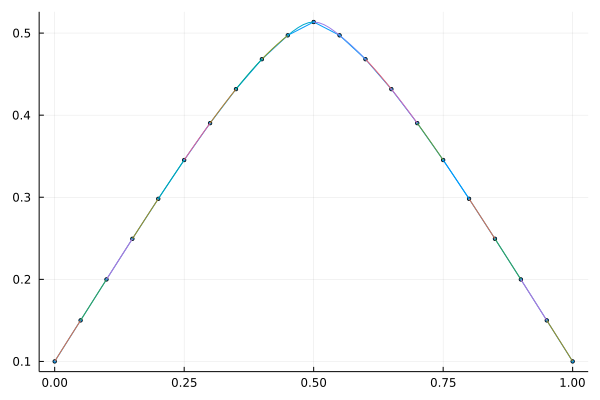

In [8]:
# vykreslení řešení aproximovaného přes kubický spline

#xn = 7

p = plot(t,u, marker=2)

for i in 1:length(u)-1
    x = t[i]:0.01:t[i+1]    
    f(x) = csc[i][1]*(x-t[i])^3 + csc[i][2]*(x-t[i])^2 + csc[i][3]*(x-t[i]) + csc[i][4]
    plot!(x, f.(x), legend=false)
end
p

In [9]:
# koeficienty 1 derivace
csc_d1 = []
for i in 1:length(csc)
    append!(csc_d1, [[3*csc[i][1],2*csc[i][2],csc[i][3]]])
end
csc_d1

20-element Vector{Any}:
 [9.721678716194646, -1.0, 1.016751251358126]
 [-1.085542074547182, -0.027832128380535233, 0.9993887814819459]
 [-1.7717098790830819, -0.13638633583525345, 0.9952833198765512]
 [-2.593329056725834, -0.31355732374356166, 0.9840347283870808]
 [-3.2782032527617604, -0.5728902294161451, 0.9618735395580882]
 [-5.007711518065328, -0.9007105546923212, 0.9250335199553765]
 [-4.059545421512085, -1.401481706498854, 0.8674787134255971]
 [-15.956923280062783, -1.8074362486500626, 0.7872557645468742]
 [11.626522696664539, -3.403128576656341, 0.656991643914214]
 [-161.5521602748928, -2.240476306989887, 0.5159015218230583]
 [161.55359319067182, -18.39569233447917, -2.694213668108514e-6]
 [-11.628308555887411, -2.2403330154119843, -0.515903327960947]
 [15.957382793477281, -3.4031638710007255, -0.6569907501212647]
 [4.059420003692275, -1.807425591652997, -0.7872554866876078]
 [5.007742126338108, -1.4014835912837695, -0.867478216261027]
 [3.278192646795234, -0.9007093786499586, -

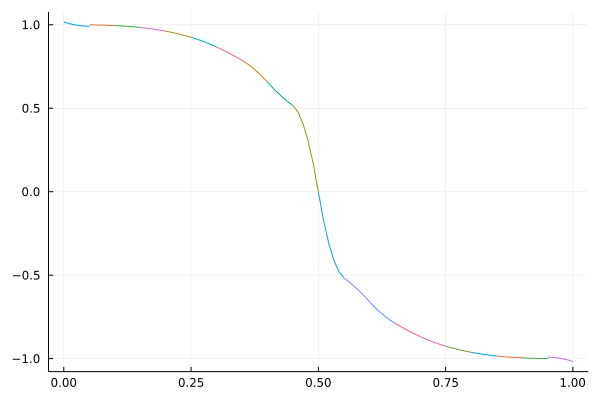

In [10]:
# vykreslení řešení aproximovaného přes kubický spline

#xn = 7

#p = plot(t,u, marker=2)
p = plot()
for i in 1:length(u)-1
    x = t[i]:0.01:t[i+1]    
    f(x) = csc_d1[i][1]*(x-t[i])^2 + csc_d1[i][2]*(x-t[i]) + csc_d1[i][3]
    plot!(x, f.(x), legend=false)
end
p

Dolní odhad prvního vlastního čísla p-laplacianu

$$\lambda_1 \geq \inf_v -\frac{\Delta_p v}{v^{p-1}} $$

kde $\Delta_p v := \left(|v'|^{p-2}v' \right)'$


**Nevím jak udělat tu finální derivaci v p-laplaciánu. Forwarddiff mi nechce fungovat na funkci, která je definovaná jako intervalový polynom**

- **problém je v té absolutní hodnotě, v tu chvíli derivace, nejde do něj interval)** - ALE SE SIGNUM SE TO ZDÁ V POŘÁDKU

- jedna z variant může být, že tu funkci (jeden oblouk splinu) zase proložím nějakým splinem a ten pak zderivuju
    - nebo spíš napočítám body na celej interval 0..1 a ty pak proložím kubickým splinem a zderivuju (to je ale strašně kompikovaný)

In [11]:

i = 3
vp(x1) = ((csc_d1[i][1]*(x1-t[i])^2 + csc_d1[i][2]*(x1-t[i]) + csc_d1[i][3])^(P-1) *
            sign((csc_d1[i][1]*(x1-t[i])^2 + csc_d1[i][2]*(x1-t[i]) + csc_d1[i][3])))  #/
            #(csc[i][1]*(x-t[i])^3 + csc[i][2]*(x-t[i])^2 + csc[i][3]*(x-t[i]) + csc[i][4])^(P-1) 
        
 


        # tenhle řádek fakt nevim, je třeba proštudovat syntaxi
#Δp = x_int -> ForwardDiff.derivative.(vp,x_int)
#Δp(1)
#vp(.1)
#pl(x) = ForwardDiff.derivative(vp,x)
#pl(0.1..0.15)

vp (generic function with 1 method)

In [12]:
num(x2) = ForwardDiff.derivative(vp,x2)
denom(x) = (csc[i][1]*(x-t[i])^3 + csc[i][2]*(x-t[i])^2 + csc[i][3]*(x-t[i]) + csc[i][4])^(P-1) 

l1(x) = -num(x)/denom(x)

l1 (generic function with 1 method)

In [13]:
l1(0.47..0.52)

[5.40763, 8.6926]

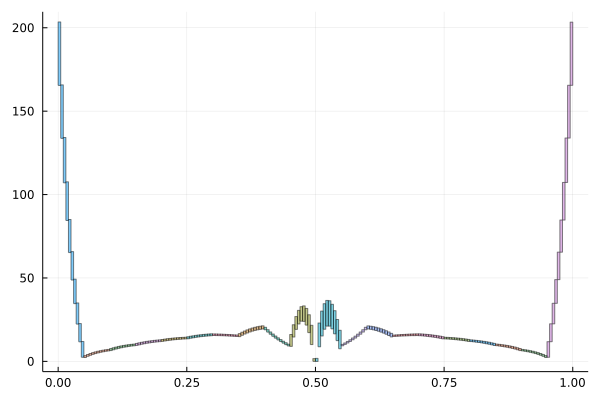

In [67]:
#a teď výpočet dolního odhadu prvního vl. číslo 

xn = 10
f(x)= 2#π^2 # 0#-π^2*sin(π*x)
p = plot()
λ_low = []
for i in 1:length(u)-1
    x_dom = t[i]..t[i+1] # domain # range(0,1,length=n)
    x_int = mince(x_dom,xn)
    vp(x1) = ((csc_d1[i][1]*(x1-t[i])^2 + csc_d1[i][2]*(x1-t[i]) + csc_d1[i][3])^(P-1) *
            sign((csc_d1[i][1]*(x1-t[i])^2 + csc_d1[i][2]*(x1-t[i]) + csc_d1[i][3])))
    num(x2) = ForwardDiff.derivative(vp,x2)
    denom(x) = (csc[i][1]*(x-t[i])^3 + csc[i][2]*(x-t[i])^2 + csc[i][3]*(x-t[i]) + csc[i][4])^(P-1) 
    l1(x) = -num(x)/denom(x)
    
    
    res = l1.(x_int)
    boxes = IntervalBox.(x_int, res)
    #println(res)
    #append!(λ_low, minimum(inf.(res)))
    plot!(boxes, legend=false)#, ylim=[8,9.95])
end
p
#λ1 = minimum(λ_low)
#println("Horní odhad λ₁: $λ1")
#println("Chyba proti přesné hodnotě: $(λ1-π^2)")

    


---
# KONEC

In [200]:
#napočtu si proloženou křivku. Otázka je, jestli to je intervalově správně

#----------
#Tak Lagrange tak nějak jde, ale jen pro malý počet bodů a ostatní ani intervalově nefunguje :-(
#-----------


#interp = QuadraticInterpolation(nsol_int,nt)
#interp3 = CubicSpline(nsol_int,nt)
#interp = BSplineInterpolation(nsol_int,nt,3,:ArcLen,:Average)

#A = CubicSpline(nsol,nt)
#B = QuadraticSpline(nsol,nt)
#C = LagrangeInterpolation(nsol,nt)
#D = BSplineInterpolation(nsol,nt,3,:ArcLen,:Average)

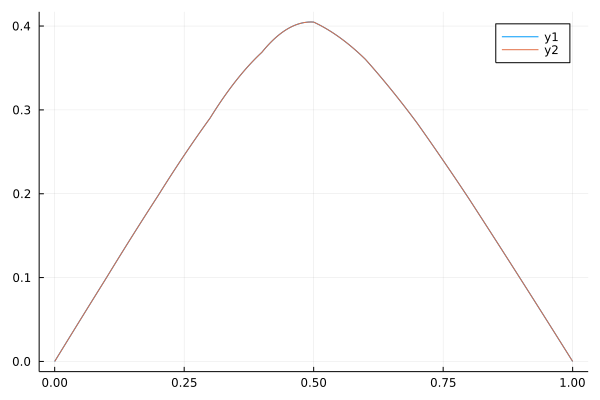

In [201]:
x = 0:.001:1
plot(x,sup.(interp.(x)))
plot!(x,inf.(interp.(x)))



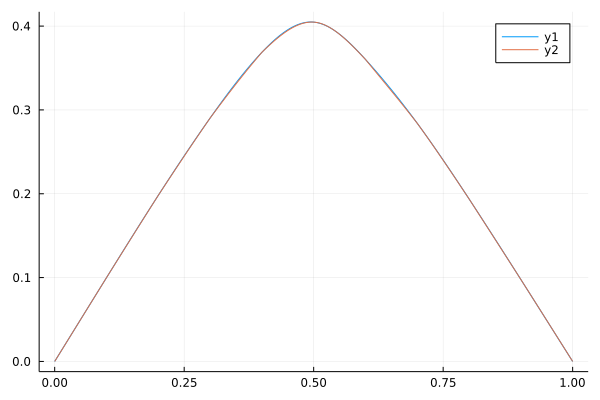

In [191]:
A = CubicSpline(nsol,nt)
#B = QuadraticSpline(nsol,nt)
#C = LagrangeInterpolation(nsol,nt)
D = BSplineInterpolation(nsol,nt,3,:ArcLen,:Average)
plot(A)
#plot!(B)
#plot!(C)
plot!(D)


In [192]:
x_dom = 0..1 # domain # range(0,1,length=n)
x_int = mince(x_dom,100)
boxes = IntervalBox.(x_int, A.(x_int))
plot(boxes)
boxesD = IntervalBox.(x_int, D.(x_int))
plot!(boxesD)

LoadError: TypeError: non-boolean (Interval{Float64}) used in boolean context

In [195]:
D

22-element BSplineInterpolation{Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, true, Float64}:
 0.0
 0.09988188531993886
 0.1981018204401105
 0.29024864713181403
 0.36868765269675996
 0.4047300657941179
 0.36022702822352104
 0.2840484740454035
 0.19386461389870713
 0.09774727205742054
 1.4590884983542136e-8
 0.0
 0.1
 0.2
 0.3
 0.4
 0.5
 0.6
 0.7
 0.8
 0.9
 1.0

In [63]:
f(u,p,t) = 0.98u
u0 = 1.0
tspan = (0.0,1.0)
prob = ODEProblem(f,u0,tspan)
sol = solve(prob, saveat=0.025)

retcode: Success
Interpolation: 1st order linear
t: 41-element Vector{Float64}:
 0.0
 0.025
 0.05
 0.075
 0.1
 0.125
 0.15
 0.175
 0.2
 0.225
 0.25
 0.275
 0.3
 ⋮
 0.725
 0.75
 0.775
 0.8
 0.825
 0.85
 0.875
 0.9
 0.925
 0.95
 0.975
 1.0
u: 41-element Vector{Float64}:
 1.0
 1.0248025920355877
 1.050220351152031
 1.0762685361970488
 1.102962785129292
 1.1303191479028185
 1.1583540296902122
 1.1870842182734156
 1.2165269512238264
 1.2466999159157592
 1.2776212495264405
 1.3093095390360159
 1.341783821227542
 ⋮
 2.035008588906576
 2.085482212305101
 2.137207615043911
 2.1902158127997695
 2.24453864623674
 2.3002087810061886
 2.3572597077467847
 2.415725742084496
 2.4756420246325916
 2.5370445209916483
 2.5999700217495443
 2.664456142481451

5.318718076379169


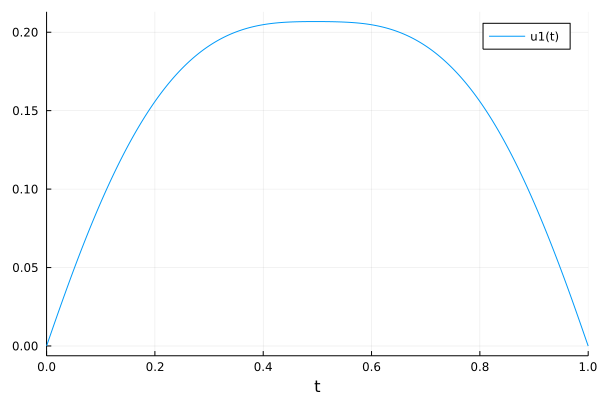

In [34]:
# nastavení p a přesná hodnota λ₁
P=1.5

λ1 = (P-1)*(2*(π/P)/(sin(π/P)))^P
println(λ1)

u0 = [0.0; 1.0;]

function sl(du,u,p,t) # parametr p je odhad na λ₁ a p z p-laplacianu
    #λ, r = p
    du[1] = abs(u[2])*u[2]
	du[2] = -λ1 * abs(u[1]+0.0000001)^(-0.5)*u[1]
end


prob = ODEProblem(sl, u0, (0.0, 1.0))
sol = solve(prob)
plot(sol,vars=(0,1))

První vlastní číslo λ₁: 9.869545326538542


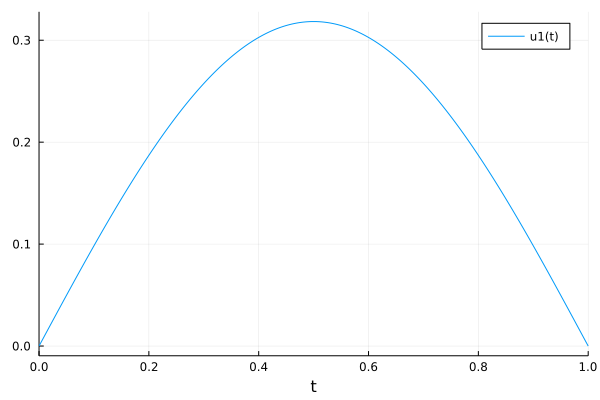

In [22]:
################
# pro S-L úlohu
###############
# řešení diferenciální soustavy
function sl(du,u,p,t) # parametr p je odhad na λ₁
	du[1] = u[2]
	du[2] = -p * u[1]
end

u0 = [0.0; 1.0;] # počáteční podmínka

e = 1e-12 # zastavovací podmínka
a,b = (3.,20.)
s = (a + b)/2

while (b-a) >= e
    prob = ODEProblem(sl, u0, (0.0, 1.0), s)
    sol = solve(prob)

    if sol(1)[1] == 0 # bere hodnotu v t=1 (pravej konec) pro první řešení soustavy u₁
        break
    else
        probA = ODEProblem(sl, u0, (0.0, 1.0), a)
        solA = solve(probA)
        
        probS = ODEProblem(sl, u0, (0.0, 1.0), s)
        solS = solve(probS)

        if solA(1)[1] * solS(1)[1] < 0
            b = s
        else
            a = s
        end
        s = (a+b)/2
    end
end
    
prob = ODEProblem(sl, u0, (0.0, 1.0), s)
sol = solve(prob)

println("První vlastní číslo λ₁: $s")
plot(sol,vars=(0,1))

In [54]:
o = -1 .. -1
println(o)
abs(o)

[-1, -1]


[1, 1]